In [1]:
# %%
import sys
sys.path.append('..')
import utils
import os
import pathlib
import argparse
from tensorboardX import SummaryWriter
import logging
from datetime import datetime
import torch 
import mymodels 
import mydataset 
from torch.utils.data import DataLoader
from utils.myfed import *
import yaml
# %%


In [2]:

yamlfilepath = pathlib.Path.cwd().parent.joinpath('config.yaml')
args = yaml.load(yamlfilepath.open('r'), Loader=yaml.FullLoader)
args = argparse.Namespace(**args)
args.datapath = "~/.data"
os.environ['CUDA_VISIBLE_DEVICES']=args.gpu

# 1. data
args.datapath = os.path.expanduser(args.datapath)

if args.dataset == 'cifar10':
    publicdata = 'cifar100'
    args.N_class = 10
elif args.dataset == 'cifar100':
    publicdata = 'imagenet'
    args.N_class = 100
elif args.dataset == 'pascal_voc2012':
    publicdata = 'mscoco'
    args.N_class = 20

assert args.dataset in ['cifar10', 'cifar100', 'pascal_voc2012']

priv_data, _, test_dataset, public_dataset, distill_loader = mydataset.data_cifar.dirichlet_datasplit(
    args, privtype=args.dataset, publictype=publicdata, N_parties=args.N_parties, online=not args.oneshot, public_percent=args.public_percent)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batchsize, shuffle=False, num_workers=args.num_workers, sampler=None)
val_loader = DataLoader(
    dataset=public_dataset, batch_size=args.batchsize, shuffle=False, num_workers=args.num_workers, sampler=None)


pascal_voc2012 mscoco
size of public dataset:  (32467, 3, 224, 224) images
size of test dataset:  (5823, 3, 224, 224) images
size of split_arr: (20, 5)
y label : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]]
Party_0 data shape: (809, 3, 224, 224)
Party_1 data shape: (1011, 3, 224, 224)
Party_2 data shape: (1132, 3, 224, 224)
Party_3 data shape: (1162, 3, 224, 224)
Party_4 data shape: (1165, 3, 224, 224)
Public data shape: (32467, 3, 224, 224)
Test data shape: (5823, 3, 224, 224)


In [3]:
args.model_name

'vit_tiny'

In [4]:
net = mymodels.define_model(modelname=args.model_name, num_classes=args.N_class)
net 

not pretrained


DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (

In [5]:
n = 0
loadname = os.path.join("/home/suncheol/code/VFL/FedMAD/checkpoints_backup/pascal_voc2012/a1.0+sd1+e300+b16+lkl", str(n)+'.pt')
if os.path.exists(loadname):
    localmodels = torch.load(loadname)
    #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
    logging.info(f'Loading Local{n}......')
    print('filepath : ', loadname)
    utils.load_dict(loadname, net)

filepath :  /home/suncheol/code/VFL/FedMAD/checkpoints_backup/pascal_voc2012/a1.0+sd1+e300+b16+lkl/0.pt


In [6]:
loadname = os.path.join("/home/suncheol/code/VFL/FedMAD/checkpoints/pascal_voc2012/a1.0+sd1+e300+b16+lkl/model-0.pth")
if os.path.exists(loadname):
    localmodels = torch.load(loadname)
    #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
    logging.info(f'Loading Local{n}......')
    print('filepath : ', loadname)
    utils.load_dict(loadname, net)

filepath :  /home/suncheol/code/VFL/FedMAD/checkpoints/pascal_voc2012/a1.0+sd1+e300+b16+lkl/model-0.pth


In [7]:
import copy
models = []
for i in range(0, 5):
    model = copy.deepcopy(net)
    loadname = os.path.join(f"/home/suncheol/code/VFL/FedMAD/checkpoints/pascal_voc2012/a1.0+sd1+e300+b16+lkl/model-{i}.pth")
    if os.path.exists(loadname):
        localmodels = torch.load(loadname)
        #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
        logging.info(f'Loading Local{n}......', 'filepath : ', loadname)
        utils.load_dict(loadname, model)
    models.append(model)

In [8]:
len(models)

5

In [9]:
# show 1 batch of data
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(test_loader)
images, labels, _ = dataiter.next()


In [10]:
grad_cam_images = []
for model in models:
    grad_cam_images.append(model.module.get_class_activation_map(images, labels))
# grayscale_cam = net.module.get_class_activation_map(images, labels)


In [11]:
grad_cam_images = torch.stack([torch.tensor(grad_cam_images[i]) for i in range(len(grad_cam_images))])
grad_cam_images.shape # n_clients * b * 224 * 224

torch.Size([5, 16, 224, 224])

In [12]:
union_cam = torch.max(grad_cam_images, dim=0)[0]
intersection_cam = torch.min(grad_cam_images, dim=0)[0]
union_cam.numpy().shape

(16, 224, 224)

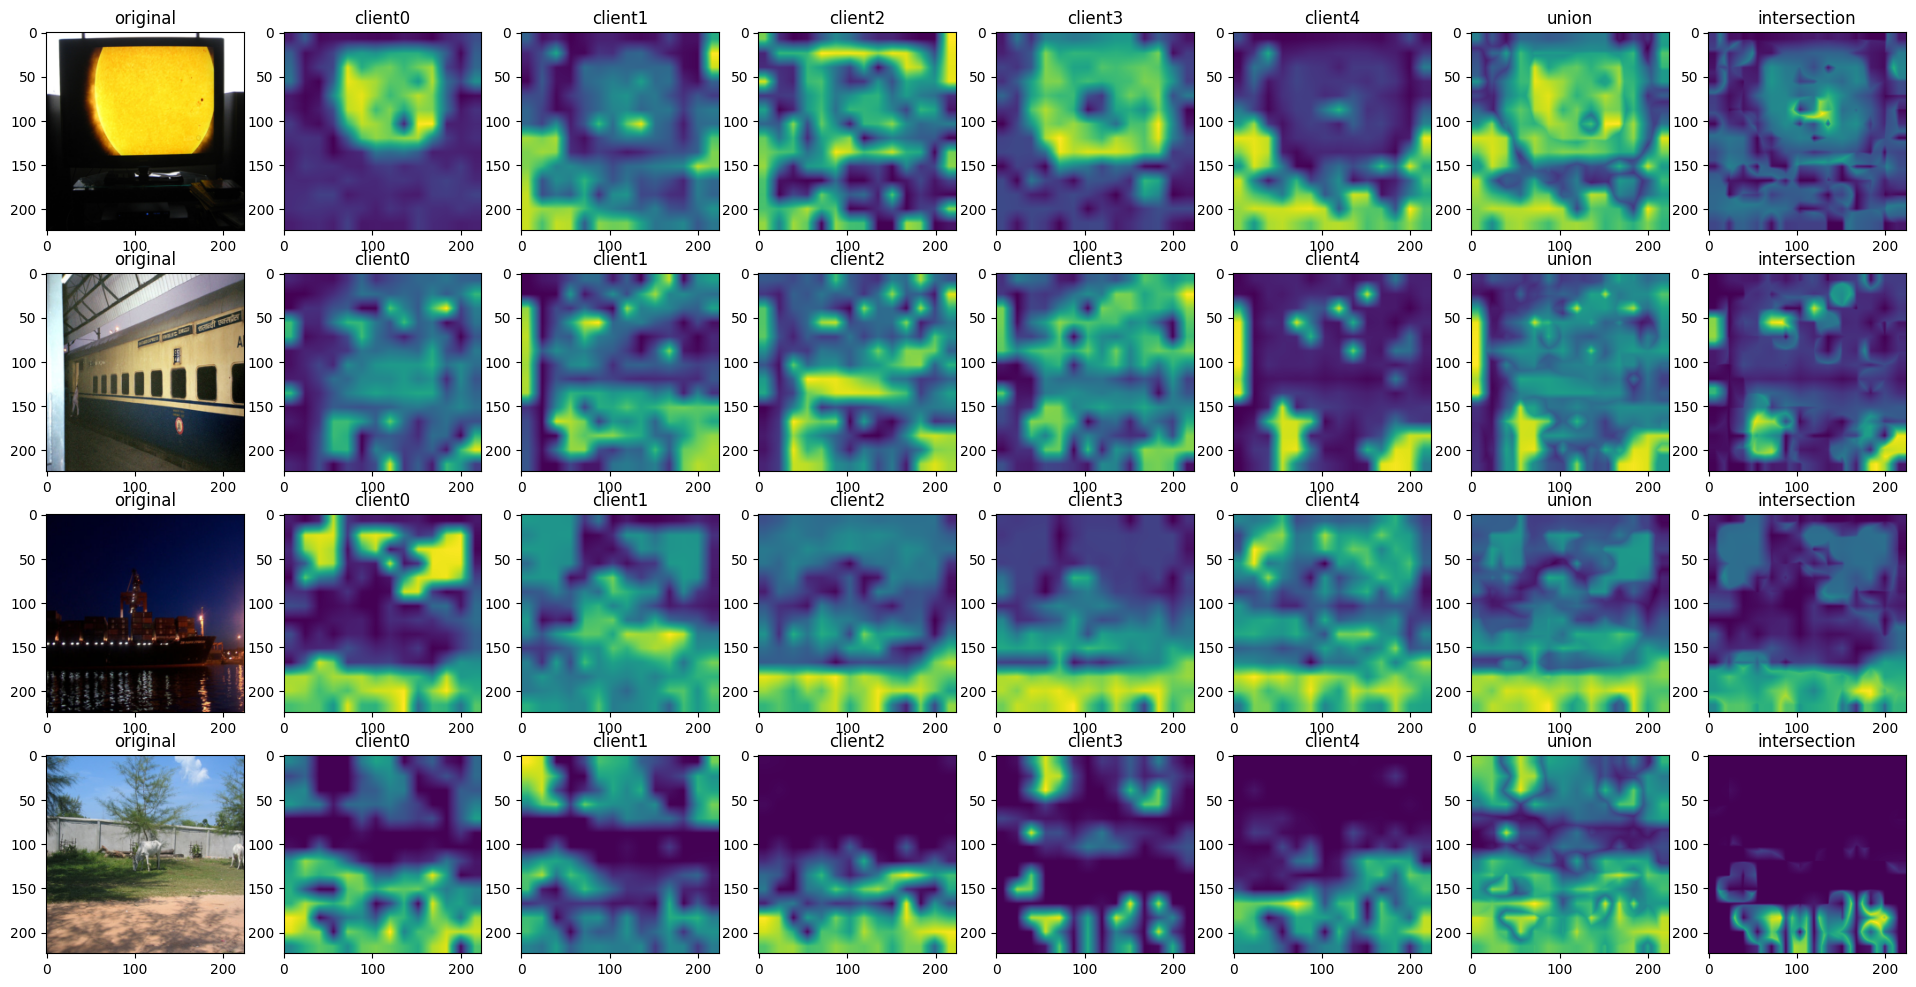

<Figure size 640x480 with 0 Axes>

In [13]:
row = 4
col = 8
import matplotlib.pyplot as plt
plt.figure(figsize=(3 * col, 3 * row))
for j in range(0, row):
    plt.subplot(row, col, j*col+1)
    plt.imshow(images[j].numpy().transpose(1, 2, 0))
    plt.title(f'original')
    for i in range(0, 5):
        plt.subplot(row, col, j*col+i+2)
        plt.imshow(grad_cam_images[i].numpy()[j])
        plt.title(f'client{i}')
    plt.subplot(row, col, j*col+7)
    plt.imshow(union_cam.numpy()[j])
    plt.title('union')
    plt.subplot(row, col, j*col+8)
    plt.imshow(intersection_cam.numpy()[j])
    plt.title('intersection')
plt.show()
plt.tight_layout()

In [ ]:
# grayscale_cam # b * 224 * 224
# grayscale_cam = torch.tensor(grayscale_cam)
# # n_clients * b * 224 * 224
# grayscale_cam = torch.stack([grayscale_cam, grayscale_cam], dim=0)


In [ ]:
# grayscale_cam.shape

In [ ]:
# grayscale_cam is batch_size x 224 x 224
# union is maximum of all CAMs 
# intersection is minimum of all CAMs
union_cam = torch.max(torch.tensor(grayscale_cam), dim=0)[0]
intersection_cam = torch.min(torch.tensor(grayscale_cam), dim=0)[0]
union_cam.numpy().shape

In [14]:
print(images.shape)
mha_images = []
for model in models:
    mha, thrs = model.module.get_attention_maps_postprocessing(images.cuda())
    # mha = model.module.get_attention_maps(images.cuda())[-1]
    # print("mha shape : ", mha.shape, "thrs shape : ", thrs.shape)
    print("mha shape : ", mha.shape)
    mha_images.append(mha)

print(len(mha_images))
mha_images = torch.stack([torch.tensor(mha_images[i]) for i in range(len(mha_images))])
print(mha_images.shape)

torch.Size([16, 3, 224, 224])
(1) x.shape = torch.Size([16, 3, 224, 224])
(2) x.shape = torch.Size([16, 197, 192])
(3) x.shape = torch.Size([16, 197, 192])
(4) x.shape = torch.Size([16, 197, 192]) attn_maps.shape = torch.Size([16, 3, 197, 197])
mha shape :  (3, 224, 224)
(1) x.shape = torch.Size([16, 3, 224, 224])
(2) x.shape = torch.Size([16, 197, 192])
(3) x.shape = torch.Size([16, 197, 192])
(4) x.shape = torch.Size([16, 197, 192]) attn_maps.shape = torch.Size([16, 3, 197, 197])
mha shape :  (3, 224, 224)
(1) x.shape = torch.Size([16, 3, 224, 224])
(2) x.shape = torch.Size([16, 197, 192])
(3) x.shape = torch.Size([16, 197, 192])
(4) x.shape = torch.Size([16, 197, 192]) attn_maps.shape = torch.Size([16, 3, 197, 197])
mha shape :  (3, 224, 224)
(1) x.shape = torch.Size([16, 3, 224, 224])
(2) x.shape = torch.Size([16, 197, 192])
(3) x.shape = torch.Size([16, 197, 192])
(4) x.shape = torch.Size([16, 197, 192]) attn_maps.shape = torch.Size([16, 3, 197, 197])
mha shape :  (3, 224, 224)
(1

In [ ]:
# imshow 


In [ ]:
# grid = torchvision.utils.make_grid(mha_images[0])
torchvision.utils.make_grid(mha_images[0])

In [ ]:
mha_images.shape
3* 197

In [ ]:
# mha_images = mha_images.reshape(5, 16, 591, 197).cpu().detach().numpy()

In [ ]:
# grayscale_cam is batch_size x 224 x 224
# union is maximum of all CAMs 
# intersection is minimum of all CAMs


In [ ]:
mha_images.reshape(5, 3, )

In [ ]:
union_cam = torch.max(torch.tensor(mha_images), dim=0)[0]
intersection_cam = torch.min(torch.tensor(mha_images), dim=0)[0]
union_cam.numpy().shape

In [ ]:
row = n_heads = 3
col = 8
import matplotlib.pyplot as plt
plt.figure(figsize=(3 * col, 3 * row))
for j in range(0, row):
    plt.subplot(row, col, j*col+1)
    plt.imshow(images[0].numpy().transpose(1, 2, 0))
    plt.title(f'original')
    for i in range(0, 5):
        plt.subplot(row, col, j*col+i+2)
        plt.imshow(mha_images[i].numpy()[j])
        plt.title(f'client{i}')
    plt.subplot(row, col, j*col+7)
    plt.imshow(union_cam.numpy()[j])
    plt.title('union')
    plt.subplot(row, col, j*col+8)
    plt.imshow(intersection_cam.numpy()[j])
    plt.title('intersection')
plt.show()
plt.tight_layout()

In [ ]:
union_cam = torch.max(mha_images, dim=0)[0]
intersection_cam = torch.min(mha_images, dim=0)[0]
union_cam.numpy().shape

In [ ]:
row = 4
col = 8
import matplotlib.pyplot as plt
plt.figure(figsize=(3 * col, 3 * row))
for j in range(0, row):
    plt.subplot(row, col, j*col+1)
    plt.imshow(images[j].numpy().transpose(1, 2, 0))
    plt.title(f'original')
    for i in range(0, 5):
        plt.subplot(row, col, j*col+i+2)
        plt.imshow(grad_cam_images[i].numpy()[j])
        plt.title(f'client{i}')
    plt.subplot(row, col, j*col+7)
    plt.imshow(union_cam.numpy()[j])
    plt.title('union')
    plt.subplot(row, col, j*col+8)
    plt.imshow(intersection_cam.numpy()[j])
    plt.title('intersection')
plt.show()
plt.tight_layout()

In [ ]:
# from __future__ import absolute_import
# from __future__ import print_function
# from __future__ import division
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class at_loss(torch.nn.Module):
#     '''
#     summary : FedAD attention loss function
#     '''
#     def __init__(self): #, T=3, singlelabel=False
#         super().__init__()
#         # self.T = T
#         # self.singlelabel = singlelabel
#         # self.criterion= torch.nn.KLDivLoss(reduction='batchmean')

#     def forward(self, inter_input, union_input, target):
#         # inter_input : ensembled gradcam image (intersection)
#         # union_input : ensembled gradcam image (union)
#         # target : central gradcam image
#         p1, b1 = 10, 0.6
#         p2, b2 = 10, 0.3
#         t_A = torch.sigmoid(-p1*(target-b1))
#         # Weighted Average sum
#         loss1 = - torch.sum(torch.dot(t_A.view(-1), inter_input.view(-1)))/torch.sum(t_A)
#         t_U = torch.sigmoid(-p2*(union_input-b2))
#         loss2 = - torch.sum(torch.dot(t_U.view(-1), target.view(-1)))/torch.sum(target)
#         print('intersection loss : ', loss1, 'union loss : ', loss2)
#         return loss1 + loss2


# def weight_gradcam(cam_images, countN):#nlcoal*batch*nclass
#     #softLogits = torch.nn.Softmax(dim=2)(logits)
#     # cam_images = n_clinets * batch size * image width * image height
#     # union is maximum of all clients cam_images = batch size * image width * image height
#     union = torch.max(torch.tensor(cam_images.clone()), dim=0)[0]
#     # intersection is minimum of all clients cam_images = batch size * image width * image height
#     intersection = torch.min(torch.tensor(cam_images.clone()), dim=0)[0]
#     return union, intersection

In [ ]:
# at_loss = at_loss()
# union_cam, intersection_cam = weight_gradcam(grayscale_cam, 2)
# at_loss(intersection_cam, union_cam, grayscale_cam[0])

$$ T(\bm A) = \frac {1}{1+exp(-\rho (\bm A-b))}. (7) $$

$$ \label {eqinter} \Loss _\text {inter}({\mathbf {\widetilde A}}, {\mathbf I}) = - \frac {1}{C} \sum _c{{\frac {\sum _{hw} {I_{hw}^{c} \cdot T(\widetilde {A}_{hw}^c; \rho _1, b_1)}}{\sum _{hw} {I_{hw}^{c}}}}}, (8) $$

$$ \label {equnion} \Loss _\text {union}({\mathbf {\widetilde A}}, {\mathbf U}) = - \frac {1}{C} \sum _c{ {\frac {\sum _{hw} {\widetilde {A}_{hw}^c \cdot T(U_{hw}^c; \rho _2, b_2)}}{\sum _{hw} {\widetilde {A}_{hw}^c}} }},
(9) $$

In [ ]:
# plt.imshow(union_cam)
# plt.imshow(intersection_cam)

In [ ]:
grayscale_cam[0].shape

In [ ]:
%matplotlib inline
plt.imshow(grayscale_cam[2])
plt.show()

In [ ]:
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
img_list = []
plt.figure(figsize=(10, 10))
for i in range(args.batchsize):
    np_input = images[i].cpu().numpy()
    np_input = np.transpose(np_input, (1, 2, 0))
    np_input.shape
    grayscale_cam_ = grayscale_cam[i]
    cam_image = show_cam_on_image(np_input, grayscale_cam_, use_rgb=True)
    img_list.append(cam_image)
    plt.subplot(4, 4, i+1)
    # plt.imshow(grayscale_cam_)
    plt.imshow(cam_image)

In [ ]:
# show images and labels
imshow(torchvision.utils.make_grid(images))
# print labels

In [ ]:
from torchvision import transforms as pth_transforms
# from visualize_attention import company_colors, apply_mask2
from PIL import Image, ImageDraw
from utils.visualize import * 
# read image 

def show_attn(net, img, index=None, nlayer=0):
    w_featmap = img.shape[-2] // 16
    h_featmap = img.shape[-1] // 16

    # attentions = vit.get_last_selfattention(img.cuda())
    # attentions = net.module.get_attention_maps(img.cuda())[-1]
    attentions = net.module.get_attention_maps(img.cuda())[nlayer]

    print('attentions shape', attentions.shape)
    print('attentions', attentions)
    nh = attentions.shape[1] # number of head
    print('number of head', nh)
    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - 0.6)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()
    print('th_attn.shape: ', th_attn.shape)
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()

    # save attentions heatmaps
    prefix = f'id{index}_' if index is not None else ''
    os.makedirs('pics/', exist_ok=True)
    torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join('pics/', "img" + ".png"))
    img = Image.open(os.path.join('pics/', "img" + ".png"))

    attns = Image.new('RGB', (attentions.shape[2] * nh, attentions.shape[1]))
    for j in range(nh):
        print('attentions[j].shape: ', attentions[j].shape)
        fname = os.path.join('pics/', "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attentions[j], format='png')
        attns.paste(Image.open(fname), (j * attentions.shape[2], 0))

    return attentions, th_attn, img, attns


# img = Image.open('../data/NIH/processed/images_001/images/00000001_000.png')
# img = img.resize((224, 224))
img = images.permute(0, 2, 3, 1)[2]
img = torch.tensor(np.array(img)).permute(2, 0, 1)
img.shape

transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
    pth_transforms.Grayscale(num_output_channels=3),
    pth_transforms.Resize([224, 224]),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

img = transform(img)
print(img.shape)
# make the image divisible by the patch size
w, h = img.shape[-2] - img.shape[-2] % 16, img.shape[-1] - img.shape[-1] % 16
print(w, h)
img = img[:, :w, :h].unsqueeze(0)
print(img.shape)
attentions, th_attn, pic_i, pic_attn = show_attn(net, img, nlayer=-1)
print("attentions.shape: ", attentions.shape)
print("th_attn.shape: ", th_attn.shape)
print("pic_i.shape: ", pic_i.size)
pic_attn_color = show_attn_color(img[0].permute(1, 2, 0).cpu().numpy(), attentions, th_attn, head=[0,1,2])
final_pic = Image.new('RGB', (pic_i.size[1] * 2 + pic_attn.size[0], pic_i.size[1]))
final_pic.paste(pic_i, (0, 0))
final_pic.paste(pic_attn_color, (pic_i.size[1], 0))
final_pic.paste(pic_attn, (pic_i.size[1] * 2, 0))
display(final_pic)

In [ ]:
len(net.module.get_attention_maps(img.cuda()))

In [ ]:
out = net(img.cuda())

In [ ]:
for i in range(12):
    attentions = net.module.get_attention_maps(img.cuda())[i]
    np_mean = np.mean(attentions.cpu().numpy())
    np_std = np.std(attentions.cpu().numpy())
    for j in range(attentions.shape[1]):
        np_mean = np.mean(attentions[:, j, :, :].cpu().numpy())
        np_std = np.std(attentions[:, j, :, :].cpu().numpy())
        print(f'layer {i} head {j} mean: {np_mean}, std: {np_std}')
    # print(f'layer {i} mean: {np_mean}, std: {np_std}')

In [ ]:
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
img_list = []
plt.figure(figsize=(10, 10))
for i in range(args.batchsize):
    np_input = images[i].cpu().numpy()
    np_input = np.transpose(np_input, (1, 2, 0))
    np_input.shape
    grayscale_cam_ = grayscale_cam[i]
    cam_image = show_cam_on_image(np_input, grayscale_cam_, use_rgb=True)
    img_list.append(cam_image)
    plt.subplot(4, 4, i+1)
    plt.imshow(grayscale_cam_)
    plt.axis('off')
plt.show()
